# Project 3: Subreddit Classification
---
Project notebook organisation:<br>
[1 - Webscraping and data acquisition](./1_webscraping_and_data_acquisition.ipynb)<br>
[2 - Preprocessing of data](./2_preprocessing.ipynb)<br>
**3 - Exploratory data analysis**(current notebook)<br>
[4 - Model Tuning and Insights](./4_modelling_and_tuning.ipynb)<br>
<br>
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import scipy.stats as stats
import warnings
from wordcloud import WordCloud, ImageColorGenerator
import regex as re

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

warnings.filterwarnings('ignore')
sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline

## Introduction
---

In this notebook Iconduct EDA on the data pre-procssed in the previous workbook. looking specifically at common words and distributions of various features such as title lengths. I will also be carrying out data cleaning and feature engineering to create features that will help to better build the classification model (in the next notebook).

### Contents
1. [Initial analysis](#Initial-analysis)
2. [Data preprocessing](#Data-preprocessing)
3. [Export data](#Export-data)


### Import Data

In [3]:
iphone = pd.read_csv('./data/iphone_combined.csv', index_col = 0)
android = pd.read_csv('./data/android_combined.csv', index_col = 0)
test = pd.read_csv('./data/train.csv', index_col = 0)


### Summary statistics

The title lengths and title length distributions are fairly similar between the two subreddits, as shown in the graphs below. r/Androidquestions had a mean title length of 9.49 words (SD = 6.42), while r/iphonehelp had a mean title length of 9.20 words (SD = 7.68).

In a similar vein, both subreddits had similar `text_len` distribution. r/Androidquestions has a mean `text_len` of 81.23 (SD = 75.62) and r/iphonehelp a mean `text_len` of 83.07 (SD = 68.10). This would mean the average cry for help on either of these reddits or question relating to wither of these mobile platforms to be fairly similar.
The shortest posts were about 36 words long for r/Androidquestions and 40 words long for r/iphonehelp while the longest posts had 104 words and 109 words respectively. Interestingly, r/Androidhelp wins the competition for the longest post length with 1021 words for its longest post (compared to only 563.0).

With the comments we notice the same trend. r/Androidquestions commenters had an average comment lenght of 105.8 (SD = 238.68) and r/iphonehelp commenters had a average comment length of 99.52 (SD = 132.39). The significantly higher standard deviation in r/Androidquestions can likely be explained by the higher max comment length of 3446 words compared to r/iphonehelp's 1300 words. It does seem like the users responding to r/Androidquestions have a lot more to say about questions asked. 

The distributions of title lengths, post lengths, and comment lengths are all right skewed (see distplots below) with lots of outliers at the upper bound (see boxplots below). The outliers will not be removed at this point, as the text they contain would be important for model training.

In [4]:
iphone.describe().T

,count,mean,std,min,25%,50%,75%,max
score,992.0,1.627016,1.473615,0.00,1.0,1.0,2.0,19.0
upvote_ratio,992.0,0.939446,0.146216,0.25,1.0,1.0,1.0,1.0
comment_count,992.0,3.656250,3.915838,0.00,1.0,2.0,5.0,28.0
comment_len,992.0,99.527218,132.391163,0.00,19.0,59.0,126.0,1300.0
title_len,992.0,9.199597,7.677958,1.00,5.0,7.0,11.0,61.0
text_len,992.0,83.073589,68.099793,1.00,40.0,66.0,109.0,563.0
subreddit,992.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0


In [5]:
android.describe().T

,count,mean,std,min,25%,50%,75%,max
score,990.0,2.365657,4.962308,0.00,1.0000,1.0,2.00,59.0
upvote_ratio,990.0,0.865758,0.199397,0.25,0.7425,1.0,1.00,1.0
comment_count,990.0,3.306061,5.591075,0.00,0.0000,2.0,4.00,68.0
comment_len,990.0,105.836364,238.683835,0.00,0.0000,37.0,114.75,3446.0
title_len,990.0,9.485859,6.417029,1.00,5.0000,8.0,12.00,56.0
text_len,990.0,81.231313,75.606159,1.00,36.0000,64.0,104.00,1021.0
subreddit,990.0,1.000000,0.000000,1.00,1.0000,1.0,1.00,1.0


In [6]:
# For a mysterious reason, despite having already run a pre-processing function and having checked for null values
# in the previous notebook, a number of null values still appear in the `text` and `comment_all` fields. This function
# rectifies that.


def nullfiller(df):   
   
    # fill in null values for posts with no comments
    df['comment_all'].fillna('notexthere', inplace = True)
    df['text'].fillna('notexthere', inplace = True)
    
    return df

In [7]:
# Run nullfiller
nullfiller(iphone);
nullfiller(android);

In [8]:
# Check for null values in 'iphone'
iphone.isnull().sum()

title            0
id               0
date_created     0
text             0
score            0
upvote_ratio     0
comment_count    0
comment_all      0
comment_len      0
title_len        0
text_len         0
subreddit        0
dtype: int64

In [9]:
# Check for null values in 'android'
android.isnull().sum()

title            0
id               0
date_created     0
text             0
score            0
upvote_ratio     0
comment_count    0
comment_all      0
comment_len      0
title_len        0
text_len         0
subreddit        0
dtype: int64

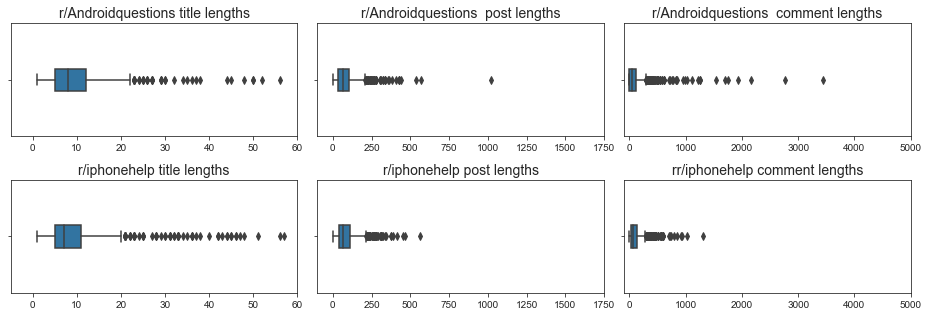

In [10]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (13, 4.5))

sns.boxplot(android['title_len'], ax = ax[0][0], width = 0.2)
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,60)
ax[0][0].set_title('r/Androidquestions title lengths', fontsize=14)
sns.boxplot(android['text_len'], ax = ax[0][1], width = 0.2)
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,1750)
ax[0][1].set_title('r/Androidquestions  post lengths', fontsize=14)
sns.boxplot(android['comment_len'], ax = ax[0][2], width = 0.2)
ax[0][2].set_xlabel('')
ax[0][2].set_xlim(-100,5000)
ax[0][2].set_title('r/Androidquestions  comment lengths', fontsize=14)

sns.boxplot(iphone['title_len'], ax = ax[1][0], width = 0.2)
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,60)
ax[1][0].set_title('r/iphonehelp title lengths', fontsize=14)
sns.boxplot(iphone['text_len'], ax = ax[1][1], width = 0.2)
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,1750)
ax[1][1].set_title('r/iphonehelp post lengths', fontsize=14)
sns.boxplot(iphone['comment_len'], ax = ax[1][2], width = 0.2)
ax[1][2].set_xlabel('')
ax[1][2].set_xlim(-100,5000)
ax[1][2].set_title('rr/iphonehelp comment lengths', fontsize=14)


plt.tight_layout()

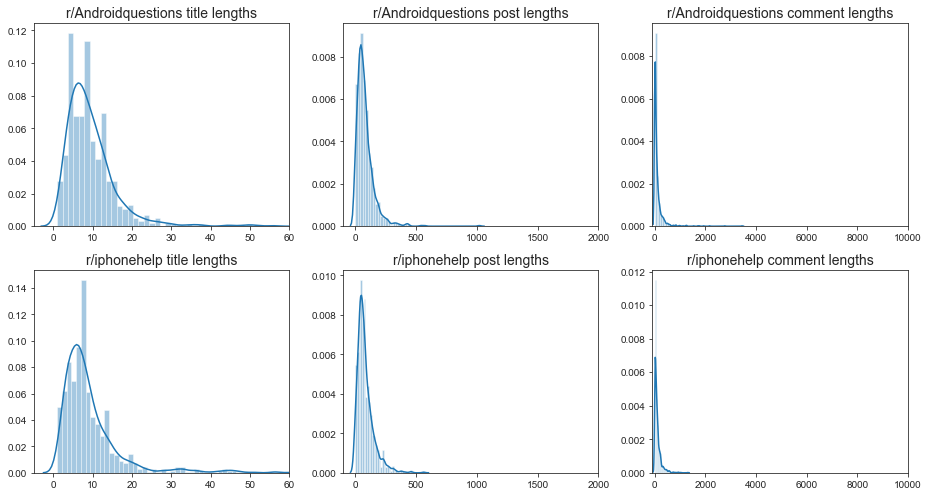

In [11]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (13, 7))

sns.distplot(android['title_len'], ax = ax[0][0])
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,60)
ax[0][0].set_title('r/Androidquestions title lengths', fontsize=14)
sns.distplot(android['text_len'], ax = ax[0][1])
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,2000)
ax[0][1].set_title('r/Androidquestions post lengths', fontsize=14)
sns.distplot(android['comment_len'], ax = ax[0][2])
ax[0][2].set_xlabel('')
ax[0][2].set_xlim(-100,10000)
ax[0][2].set_title('r/Androidquestions comment lengths', fontsize=14)

sns.distplot(iphone['title_len'], ax = ax[1][0])
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,60)
ax[1][0].set_title('r/iphonehelp title lengths', fontsize=14)
sns.distplot(iphone['text_len'], ax = ax[1][1])
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,2000)
ax[1][1].set_title('r/iphonehelp post lengths', fontsize=14)
sns.distplot(iphone['comment_len'], ax = ax[1][2])
ax[1][2].set_xlabel('')
ax[1][2].set_xlim(-100,10000)
ax[1][2].set_title('r/iphonehelp comment lengths', fontsize=14)

plt.tight_layout()

## Content Analysis

A simple count vectoriser (using the default `sklearn`'s english stop words and without any customised parameters) was used to transform the text data and to extract n-grams for preliminary visualisations. Bi-grams and tri-grams were used to extract some context.

**Titles :**
Some differences between the two subreddits are already apparent from the graphs below. Some topics specific to r/Androidquestions (as seen in the post titles) include 'Android 10', 'Samsung Galaxy', 'sd card', while those unique to r/iphonehelp include 'iphone', 'icloud', and 'ios'. It is interesting to note that the most used words in the r/Androidquestions corpus is based on the operating system whereas the most used words for r/iphonehelp is hardware-based, relating to the latest iphonee, the iphone 11. Other interesting things to note include the Android phone of choise, the Samsung galaxy series. One can hazard a guess that the problems related to Android systems are mostly software related as opposed to hardware-related for the iphone. 

**Text :**
Examining the content of the two subreddits, one can immediately see that some words such as 'don know', 'does know', 'hey guys' and 'hi guys' need to be included in the list of stop words as these phrases provide little information pertaining to features of either system. While 'Android 10' still stays at the top of the most used list in r/Androidquestions, ios 13 now becomes the most prevalent word, possibly indicating most solutions to issues related to iphones can be resolved using software tweaks. 

**Comments :**
The comments of the different subreddits appear to follow a similar trend to the titles and text, although it is curious that r/Androidquestions appear to have 'factory reset' as one of the top solutions to the problem. That is as opposed to words such as 'make sure' in r/iphonehelp which seem to indicate changing settings are the easiest way to handle most iphone-related problems

**Inersecting words :**
All three sources of data appear to generate a list of top 50 words that appear in both iphone and android. These likely should be added to the list of stop words as they do not add to the model's binary classification ability.

In [12]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

### Title content

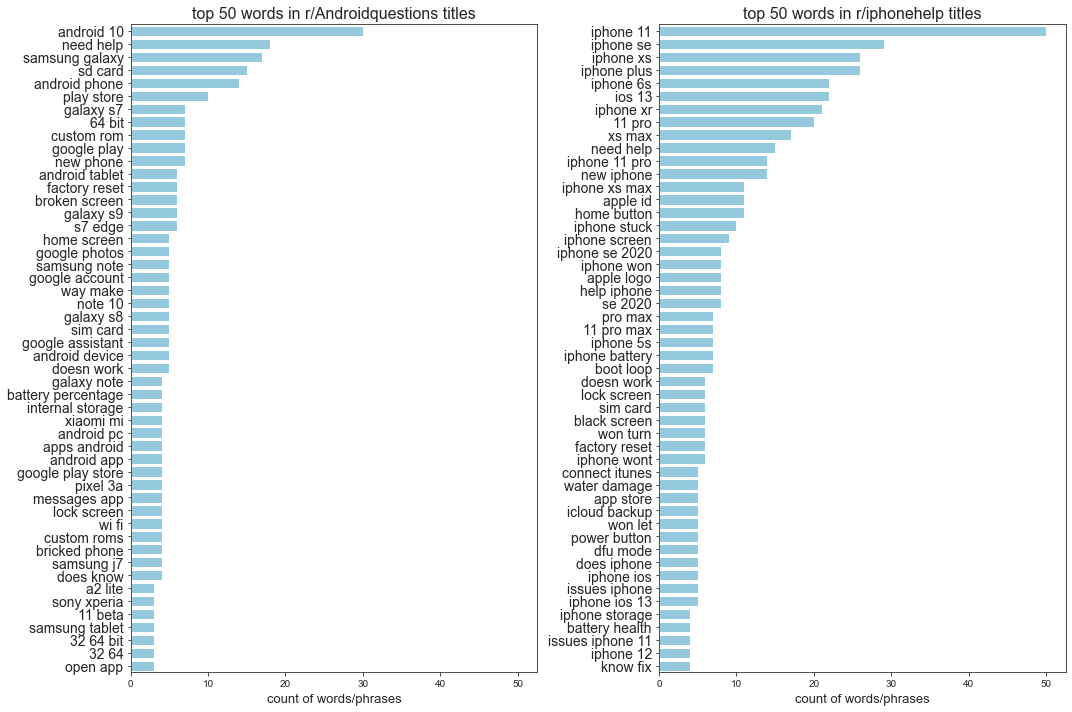

In [36]:
# r/Androidquestions - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_and = cvec.fit_transform(android['title'])
vec_and = pd.DataFrame(vec_and.toarray(), columns = cvec.get_feature_names())
and_title_50 = vec_and.sum().sort_values(ascending=False).head(50)

# r/iphonehelp - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_iph = cvec.fit_transform(iphone['title'])
vec_iph = pd.DataFrame(vec_iph.toarray(), columns = cvec.get_feature_names())
iph_title_50 = vec_iph.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=and_title_50.index.values, x = and_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/Androidquestions titles',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=iph_title_50.index.values, x = iph_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/iphonehelp titles',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

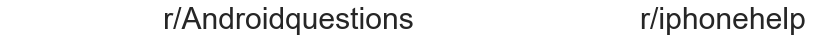

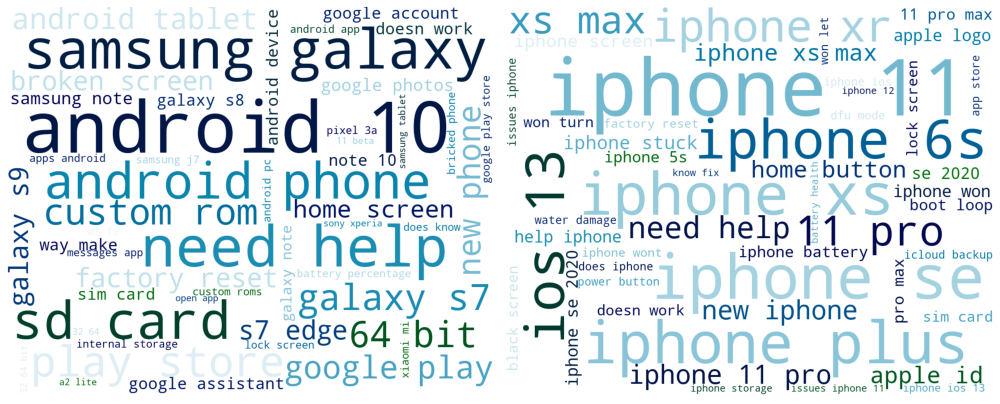

In [37]:
# set up WordCloud
wc_android = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(and_title_50) 

wc_iphone = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(iph_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/Androidquestions                           r/iphonehelp', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_android)
ax[0].axis('off')
ax[1].imshow(wc_iphone)
ax[1].axis('off')
plt.tight_layout()

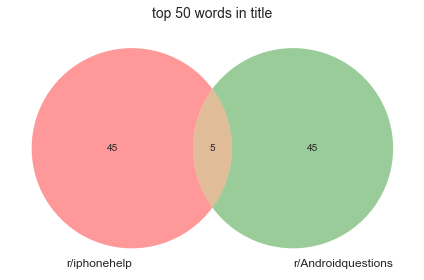

In [38]:
venn2([set(iph_title_50.index), set(and_title_50.index)], set_labels = ('r/iphonehelp','r/Androidquestions'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

In [39]:
#Create df for android for list of unique words
android_top_50_title = pd.DataFrame(and_title_50)
android_top_50_title = android_top_50_title.reset_index()
android_top_50_title.rename({'index': 'unique_word', '0': 'count'}, axis=1, inplace = True)
android_top_50_title.head()

#Create df for iphone for list of unique words
iphone_top_50_title = pd.DataFrame(iph_title_50)
iphone_top_50_title = iphone_top_50_title.reset_index()
iphone_top_50_title.rename({'index': 'unique_word', '0': 'count'}, axis=1, inplace = True)
iphone_top_50_title.head()

# Merge both dfs to get a df of only the unique words
unique_words = pd.merge(android_top_50_title, iphone_top_50_title, how='inner', left_on='unique_word', right_on='unique_word')

#Drop ununused columns
unique_words.drop(['0_x', '0_y'], axis=1, inplace = True)

unique_words.rename({'unique_word': 'Intersecting Unique Words'}, axis=1, inplace = True)
print(unique_words['Intersecting Unique Words'].ravel())

['need help' 'factory reset' 'sim card' 'doesn work' 'lock screen']


### Text content

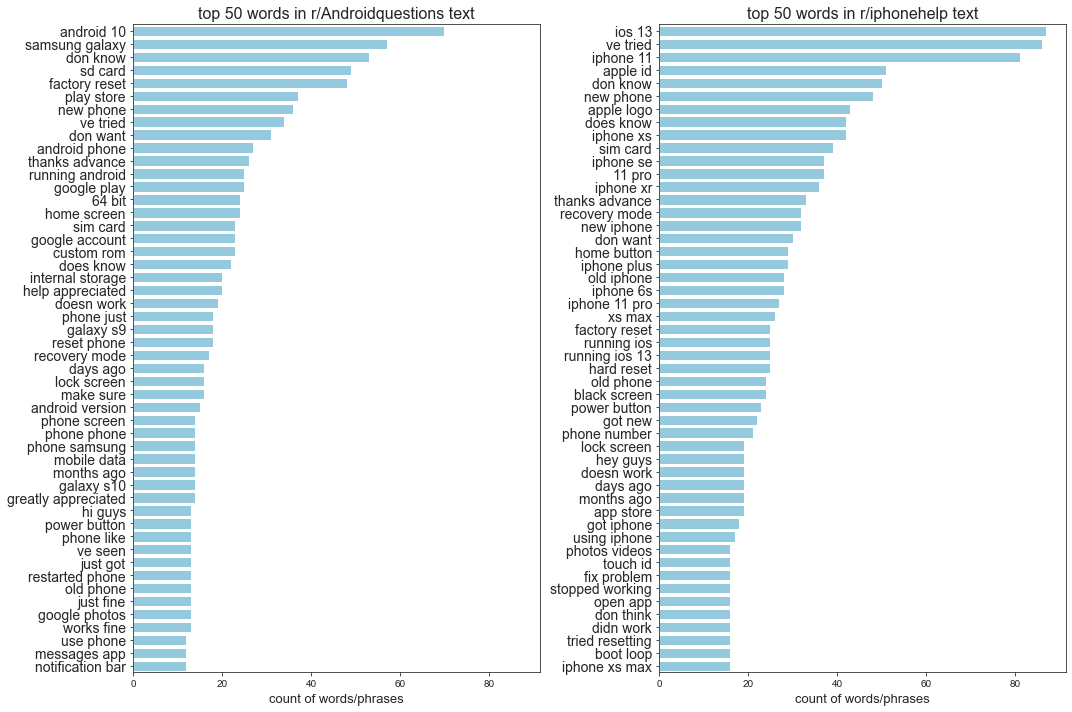

In [32]:
# r/Androidquestions - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_and = cvec.fit_transform(android['text'])
vec_and = pd.DataFrame(vec_and.toarray(), columns = cvec.get_feature_names())
and_title_50 = vec_and.sum().sort_values(ascending=False).head(50)

# r/iphonehelp - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_iph = cvec.fit_transform(iphone['text'])
vec_iph = pd.DataFrame(vec_iph.toarray(), columns = cvec.get_feature_names())
iph_title_50 = vec_iph.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=and_title_50.index.values, x = and_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/Androidquestions text',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=iph_title_50.index.values, x = iph_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/iphonehelp text',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

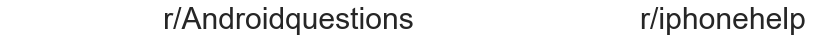

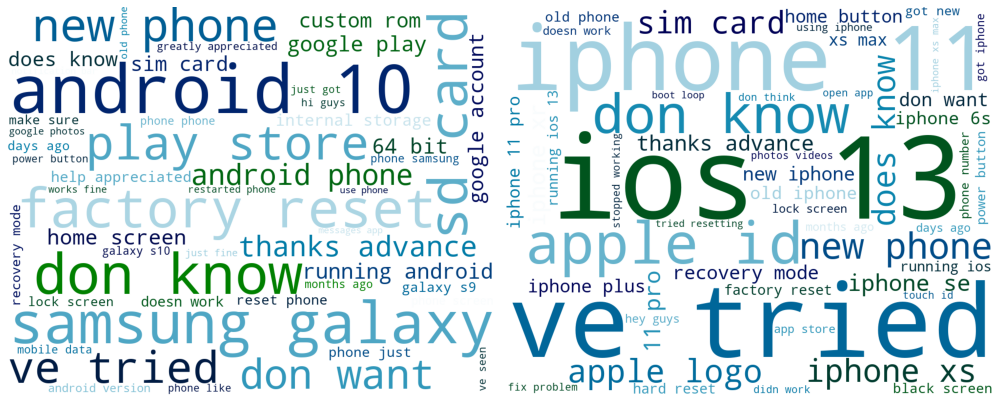

In [33]:
# set up WordCloud
wc_android = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(and_title_50) 

wc_iphone = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(iph_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/Androidquestions                           r/iphonehelp', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_android)
ax[0].axis('off')
ax[1].imshow(wc_iphone)
ax[1].axis('off')
plt.tight_layout()

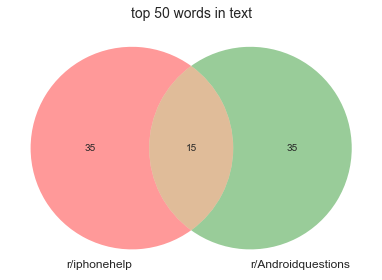

In [34]:
venn2([set(iph_title_50.index), set(and_title_50.index)], set_labels = ('r/iphonehelp','r/Androidquestions'))
plt.title('top 50 words in text', fontsize=14)
plt.tight_layout()

In [35]:
#Create df for android for list of unique words
android_top_50_text = pd.DataFrame(and_title_50)
android_top_50_text = android_top_50_text.reset_index()
android_top_50_text.rename({'index': 'unique_word', '0': 'count'}, axis=1, inplace = True)
android_top_50_text.head()

#Create df for iphone for list of unique words
iphone_top_50_text = pd.DataFrame(iph_title_50)
iphone_top_50_text = iphone_top_50_text.reset_index()
iphone_top_50_text.rename({'index': 'unique_word', '0': 'count'}, axis=1, inplace = True)
iphone_top_50_text.head()

# Merge both dfs to get a df of only the unique words
unique_words = pd.merge(android_top_50_text, iphone_top_50_text, how='inner', left_on='unique_word', right_on='unique_word')

#Drop ununused columns
unique_words.drop(['0_x', '0_y'], axis=1, inplace = True)

unique_words.rename({'unique_word': 'Intersecting Unique Words'}, axis=1, inplace = True)
print(unique_words['Intersecting Unique Words'].ravel())

['don know' 'factory reset' 'new phone' 've tried' 'don want'
 'thanks advance' 'sim card' 'does know' 'doesn work' 'recovery mode'
 'days ago' 'lock screen' 'months ago' 'power button' 'old phone']


### Comment content

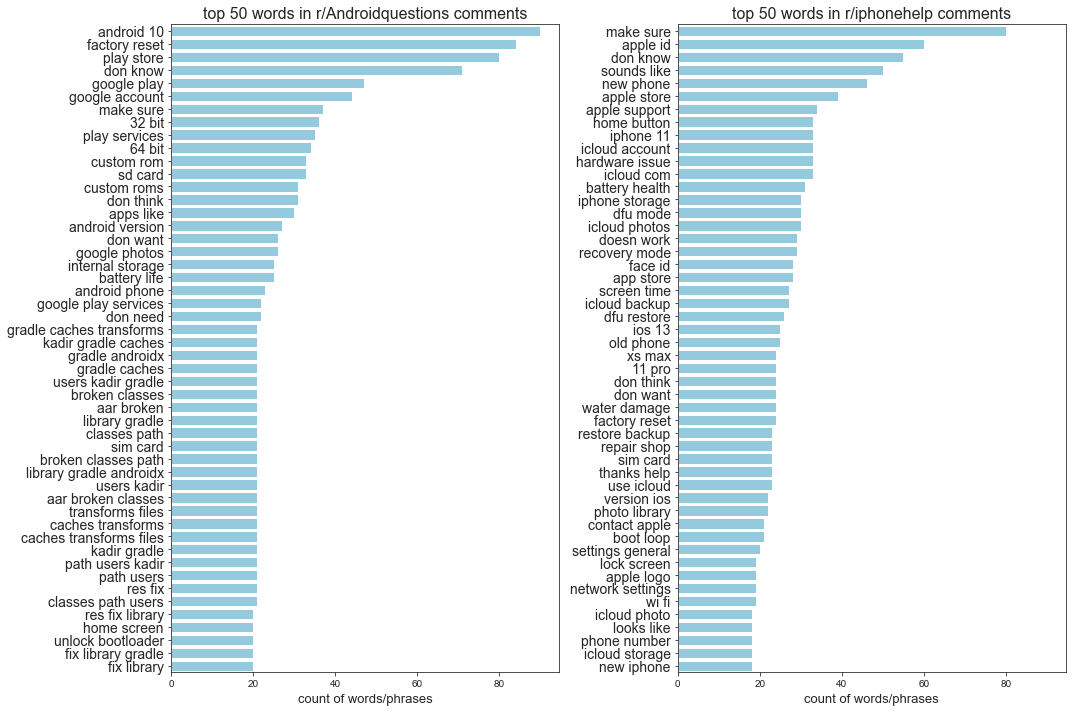

In [21]:
# r/Androidquestions - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_and = cvec.fit_transform(android['comment_all'])
vec_and = pd.DataFrame(vec_and.toarray(), columns = cvec.get_feature_names())
and_title_50 = vec_and.sum().sort_values(ascending=False).head(50)

# r/iphonehelp - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_iph = cvec.fit_transform(iphone['comment_all'])
vec_iph = pd.DataFrame(vec_iph.toarray(), columns = cvec.get_feature_names())
iph_title_50 = vec_iph.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=and_title_50.index.values, x = and_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/Androidquestions comments',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=iph_title_50.index.values, x = iph_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/iphonehelp comments',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

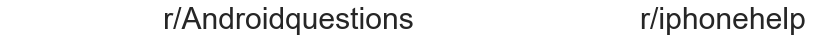

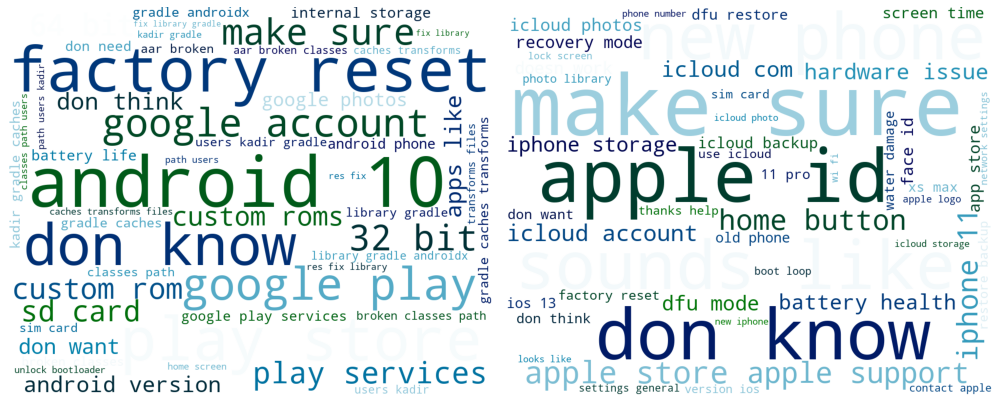

In [22]:
# set up WordCloud
wc_android = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(and_title_50) 

wc_iphone = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(iph_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/Androidquestions                           r/iphonehelp', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_android)
ax[0].axis('off')
ax[1].imshow(wc_iphone)
ax[1].axis('off')
plt.tight_layout()

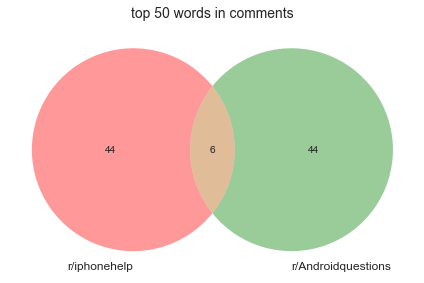

In [23]:
venn2([set(iph_title_50.index), set(and_title_50.index)], set_labels = ('r/iphonehelp','r/Androidquestions'))
plt.title('top 50 words in comments', fontsize=14)
plt.tight_layout()

In [30]:
#Create df for android for list of unique words
android_top_50_comment = pd.DataFrame(and_title_50)
android_top_50_comment = android_top_50_comment.reset_index()
android_top_50_comment.rename({'index': 'unique_word', '0': 'count'}, axis=1, inplace = True)
android_top_50_comment.head()

#Create df for iphone for list of unique words
iphone_top_50_comment = pd.DataFrame(iph_title_50)
iphone_top_50_comment = iphone_top_50_comment.reset_index()
iphone_top_50_comment.rename({'index': 'unique_word', '0': 'count'}, axis=1, inplace = True)
iphone_top_50_comment.head()

# Merge both dfs to get a df of only the unique words
unique_words = pd.merge(android_top_50_comment, iphone_top_50_comment, how='inner', left_on='unique_word', right_on='unique_word')

#Drop ununused columns
unique_words.drop(['0_x', '0_y'], axis=1, inplace = True)

unique_words.rename({'unique_word': 'Intersecting Unique Words'}, axis=1, inplace = True)
print(unique_words['Intersecting Unique Words'].ravel())


['factory reset' 'don know' 'make sure' 'don think' 'don want' 'sim card']


## Summary of EDA

From EDA, it was apparent that the preprocessed data might still require a small amount of cleaning. Intersecting words for the Titles, Comments and Text will have to be added to the list of stop words as they are likely to confuse the model as to the distinctiveness of the corpus, thereby reducing its effectiveness as a predictor.

In the next notebook, I will examine how each feature contribute to the final model results, and how well the model is able to distinguish between the two subreddits.